In [2]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 51.5085,
    "longitude": -0.1257,
    "hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m"],
    "temperature_unit": "fahrenheit",
    "wind_speed_unit": "ms",
    "forecast_days": 7
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(5).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["dew_point_2m"] = hourly_dew_point_2m
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)

# Save to CSV
csv_filename = "london_hourly_weather.csv"
hourly_dataframe.to_csv(csv_filename, index=False)
print(f"CSV saved: {csv_filename}")

print(hourly_dataframe)

Coordinates 51.5°N -0.12000012397766113°E
Elevation 23.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
CSV saved: london_hourly_weather.csv
                         date  temperature_2m  relative_humidity_2m  \
0   2025-02-08 00:00:00+00:00       39.623001                  86.0   
1   2025-02-08 01:00:00+00:00       39.983002                  86.0   
2   2025-02-08 02:00:00+00:00       40.342999                  85.0   
3   2025-02-08 03:00:00+00:00       40.342999                  84.0   
4   2025-02-08 04:00:00+00:00       40.612999                  85.0   
..                        ...             ...                   ...   
163 2025-02-14 19:00:00+00:00       35.705299                  80.0   
164 2025-02-14 20:00:00+00:00       35.795300                  82.0   
165 2025-02-14 21:00:00+00:00       35.795300                  83.0   
166 2025-02-14 22:00:00+00:00       35.615299                  83.0   
167 2025-02-14 23:00:00+00:00       35.255299                  82.0

In [4]:
import pandas as pd
fut_df = pd.read_csv(csv_filename)

In [6]:
fut_df.head()

,date,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m,wind_direction_10m,wind_gusts_10m
0,2025-02-08 00:00:00+00:00,39.623,86.0,35.781254,3.354102,63.435013,7.8
1,2025-02-08 01:00:00+00:00,39.983,86.0,36.135067,3.178050,65.854460,7.1
2,2025-02-08 02:00:00+00:00,40.343,85.0,36.192772,3.400000,61.927620,7.5
3,2025-02-08 03:00:00+00:00,40.343,84.0,35.893574,3.935734,62.783974,7.2
4,2025-02-08 04:00:00+00:00,40.613,85.0,36.457767,3.911521,57.528828,8.3


In [10]:
fut_df.rename(columns={'date': 'Time'}, inplace=True)
fut_df['Time'] = pd.to_datetime(fut_df['Time'])
fut_df['Year']=fut_df['Time'].dt.year
fut_df['Month']=fut_df['Time'].dt.month

In [12]:
fut_df['Hour'] = fut_df['Time'].dt.hour

In [14]:
fut_df

,Time,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m,wind_direction_10m,wind_gusts_10m,Year,Month,Hour
0,2025-02-08 00:00:00+00:00,39.6230,86.0,35.781254,3.354102,63.435013,7.8,2025,2,0
1,2025-02-08 01:00:00+00:00,39.9830,86.0,36.135067,3.178050,65.854460,7.1,2025,2,1
2,2025-02-08 02:00:00+00:00,40.3430,85.0,36.192772,3.400000,61.927620,7.5,2025,2,2
3,2025-02-08 03:00:00+00:00,40.3430,84.0,35.893574,3.935734,62.783974,7.2,2025,2,3
4,2025-02-08 04:00:00+00:00,40.6130,85.0,36.457767,3.911521,57.528828,8.3,2025,2,4
...,...,...,...,...,...,...,...,...,...,...
163,2025-02-14 19:00:00+00:00,35.7053,80.0,30.143423,3.667424,78.996506,8.9,2025,2,19
164,2025-02-14 20:00:00+00:00,35.7953,82.0,30.839970,3.612478,85.236440,8.8,2025,2,20
165,2025-02-14 21:00:00+00:00,35.7953,83.0,31.139446,3.600000,90.000000,8.8,2025,2,21
166,2025-02-14 22:00:00+00:00,35.6153,83.0,30.963224,3.601389,91.591110,8.6,2025,2,22


In [16]:
import numpy as np
min_year = fut_df['Year'].min()
max_year = fut_df['Year'].max()
fut_df['Month_sin'] = np.sin(2 * np.pi * fut_df['Month'] / 12)
fut_df['Month_cos'] = np.cos(2 * np.pi * fut_df['Month'] / 12)

In [18]:
fut_df['Day'] = fut_df['Time'].dt.day
fut_df['Day_sin'] = np.sin(2 * np.pi * fut_df['Day'] / 31) 
fut_df['Day_cos'] = np.cos(2 * np.pi * fut_df['Day'] / 31)
fut_df['Hour_sin'] = np.sin(2 * np.pi * fut_df['Hour'] / 24) 
fut_df['Hour_cos'] = np.cos(2 * np.pi * fut_df['Hour'] / 24)

In [20]:
fut_df.head()

,Time,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m,wind_direction_10m,wind_gusts_10m,Year,Month,Hour,Month_sin,Month_cos,Day,Day_sin,Day_cos,Hour_sin,Hour_cos
0,2025-02-08 00:00:00+00:00,39.623,86.0,35.781254,3.354102,63.435013,7.8,2025,2,0,0.866025,0.5,8,0.998717,-0.050649,0.000000,1.000000
1,2025-02-08 01:00:00+00:00,39.983,86.0,36.135067,3.178050,65.854460,7.1,2025,2,1,0.866025,0.5,8,0.998717,-0.050649,0.258819,0.965926
2,2025-02-08 02:00:00+00:00,40.343,85.0,36.192772,3.400000,61.927620,7.5,2025,2,2,0.866025,0.5,8,0.998717,-0.050649,0.500000,0.866025
3,2025-02-08 03:00:00+00:00,40.343,84.0,35.893574,3.935734,62.783974,7.2,2025,2,3,0.866025,0.5,8,0.998717,-0.050649,0.707107,0.707107
4,2025-02-08 04:00:00+00:00,40.613,85.0,36.457767,3.911521,57.528828,8.3,2025,2,4,0.866025,0.5,8,0.998717,-0.050649,0.866025,0.500000


In [ ]:
""" import pickle
with open('random_forest_model.pkl', 'rb') as f:
    model = pickle.load(f)
 """
import joblib
model = joblib.load("random_forest_model.pkl")

In [28]:
fut_df.rename(columns={"relative_humidity_2m":"relativehumidity_2m", "dew_point_2m":"dewpoint_2m", "wind_speed_10m":"windspeed_10m", "wind_direction_10m":"winddirection_10m", "wind_gusts_10m":"windgusts_10m"}, inplace=True)

In [30]:
pred_df = fut_df.drop(columns=["Time","Day","Year","Month","Hour"])
y_pred = model.predict(pred_df)

In [32]:
y_pred

array([0.39734117, 0.35602333, 0.4071735 , 0.60421467, 0.57851533,
       0.41766817, 0.32673833, 0.30633933, 0.28302167, 0.23001267,
       0.20219533, 0.26120633, 0.189332  , 0.27964467, 0.26443733,
       0.31013367, 0.36934033, 0.32640667, 0.41204   , 0.28261304,
       0.23807042, 0.24778452, 0.22914072, 0.21565549, 0.18387854,
       0.18959442, 0.19606009, 0.18203617, 0.18453178, 0.17083434,
       0.18088883, 0.16159967, 0.189051  , 0.26774833, 0.19417467,
       0.394026  , 0.35264144, 0.34595011, 0.17529267, 0.44621667,
       0.58726833, 0.46688867, 0.63460633, 0.60059333, 0.33500117,
       0.45943567, 0.392648  , 0.47810567, 0.65078   , 0.7463064 ,
       0.74875733, 0.75526467, 0.82520008, 0.75525733, 0.760158  ,
       0.59329767, 0.49173933, 0.441177  , 0.46193833, 0.46485467,
       0.44281467, 0.34849933, 0.25457833, 0.254049  , 0.23216667,
       0.26872167, 0.28812967, 0.32292033, 0.2498077 , 0.2512197 ,
       0.332352  , 0.311826  , 0.274243  , 0.27885997, 0.21282

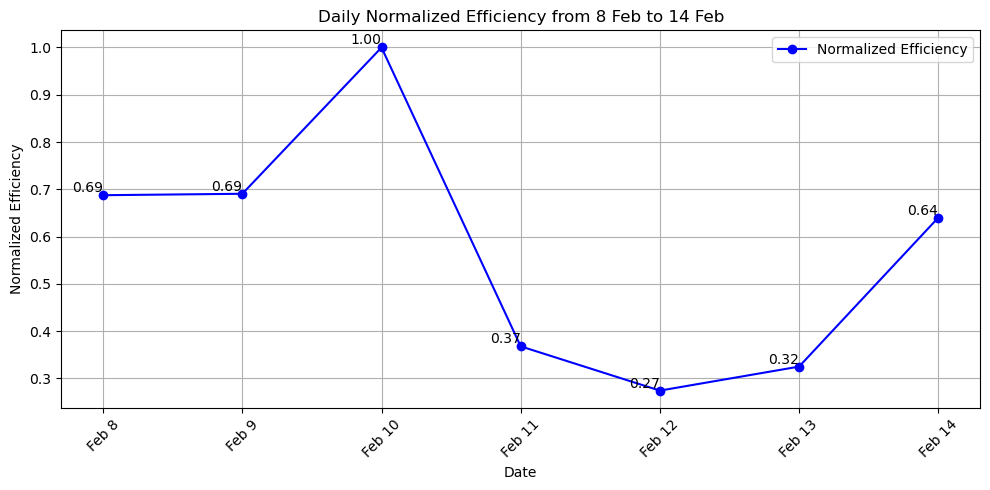

'normalized_efficiency_plot.png'

In [34]:
import numpy as np
import matplotlib.pyplot as plt

efficiency_values = y_pred

daily_efficiency = efficiency_values.reshape(-1, 24).sum(axis=1)
normalized_efficiency = daily_efficiency / daily_efficiency.max()  # Normalize

dates = [f"Feb {i}" for i in range(8, 15)]

plt.figure(figsize=(10, 5))
plt.plot(dates, normalized_efficiency, marker='o', linestyle='-', color='b', label="Normalized Efficiency")

for i, txt in enumerate(normalized_efficiency):
    plt.text(dates[i], normalized_efficiency[i], f"{txt:.2f}", ha='right', va='bottom', fontsize=10)

plt.xlabel("Date")
plt.ylabel("Normalized Efficiency")
plt.title("Daily Normalized Efficiency from 8 Feb to 14 Feb")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Save the figure
image_path = "normalized_efficiency_plot.png"
plt.savefig(image_path, dpi=300)
plt.show()

image_path


In [ ]:
df_efficiency = pd.DataFrame({
    "Date": dates,
    "Normalized_Efficiency": normalized_efficiency
})

# Save to CSV
csv_path = "efficiency_data.csv"
df_efficiency.to_csv(csv_path, index=False)

# Display the table
print(df_efficiency)

csv_path

     Date  Normalized Efficiency
0   Feb 8               0.687449
1   Feb 9               0.690473
2  Feb 10               1.000000
3  Feb 11               0.367644
4  Feb 12               0.274000
5  Feb 13               0.324785
6  Feb 14               0.639879


'efficiency_data.csv'